# 作业一 图像处理基础

* 作业分为三个部分,主要内容分别为**卷积, 滤波器和单应性**
* 题型分为两种, 分别是**文字证明题**和需补充代码的**编程题**

> 请在题目指定的位置上写文字或者代码, **不允许在规定范围之外**对笔记本进行改动
“
> 提交缓存好**结果**的ipynb文件(提交之前`restart kernel and run all cells`)

> 有问题请联系助教王怡力, 微信号Amberyili, 邮箱amberwangyili@gmail.com

In [1]:
# 需要导入的module
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io
from scipy import ndimage

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# some helper functions
def show_image(img, zoom=1.5):
    dpi = 77
    plt.figure(figsize=(img.shape[0]*zoom/dpi,img.shape[0]*zoom/dpi))
    plt.axis('off')
    if len(img.shape) == 2:
        img = np.repeat(img[:,:,np.newaxis],3,2)        
    plt.imshow(img, interpolation='nearest')
    
def show_images(imglist, zoom=1, needs_encoding=False):
    if type(imglist) is not list:
        imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 77
    plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        plt.subplot(1,n,i + 1)
        plt.tight_layout()    
        plt.axis('off')
        if len(img.shape) == 2:
            img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.imshow(img, interpolation='nearest')    

## 第一部分 卷积 (20分)

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 1.1 交换律 (5 分)

 给出图像的表示 $f:\mathbb{R}^2\rightarrow \mathbb{R}$和卷积核的表示 $h:\mathbb{R}^2\rightarrow\mathbb{R}$后, 我们可以定义卷积操作为:
 
$$(f*h)[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-i,n-j]$$

或等价的,
\begin{align}
(f*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty h[i,j]\cdot f[m-i,n-j]\\
&= (h*f)[m,n]
\end{align}


证明此结论,即$f*h = h*f$.

**Answer:**

作替换$a=m-i, b=n-j$，可以得到
$$(f*h)[m,\,n]=\sum_{i=-\infty}^{\infty}\sum_{j=-\infty}^{\infty}f[i,\,j]\cdot h[m-i,\,n-j]=\sum_{a=-\infty}^{\infty}\sum_{b=-\infty}^{\infty}h[a,\,b]\cdot f[m-a,\,n-b]=(h*f)[m,\,n]$$

从而有$f*h=h*f$

### 1.2 平移不变性 (5 分)
证明卷积操作和平移操作是[可交换的](https://en.wikipedia.org/wiki/Convolution#Translation_invariance) (定义描述参考此链接)

**Answer**:
    考虑平移operator $\tau_x$，它被定义为$(\tau_x f)(y)=f(y-x)$，
    那么
    $$\tau_x((f*g)(t))=\tau_x\left(\int_{-\infty}^{+\infty}f(\tau)g(t-\tau)\mathrm{d}\tau\right)=\int_{-\infty}^{+\infty}f(\tau)g(t-x-\tau)\mathrm{d}\tau=f*(\tau_x g) (t) $$ 利用卷积的交换律，可以得到
    $$\tau_x(f*g)=\tau_x(g*f)=g*(\tau_x f)=(\tau_x f)*g=f*(\tau_x g)$$ 由此卷积的平移不变性得证。
    连续卷积的情形可以直接推广到离散卷积，在此不赘述。

### 1.3 可分离滤波器 (10分)
1.  对于一个2D的卷积核, 如果它能被表示为两个向量的外积操作, 即$F=F_1F_2$, 我们称该滤波器为可分离的滤波器,请证明性质$I*F=(I*F_1)*F_2$ (5分)

**Answer:**

设$F=(f_{ij})_{(h\times w)}$，如果它可分离，那么$f_{ij} = F_1(i) F_2(j)$
$$(I*F)[m, n]=\sum_{i=1}^{h}\sum_{j=1}^{w}F[i, j]\cdot I[m - i, n - j]\\
=\sum_{i=1}^h\sum_{j=1}^w F_1(i)F_2(j)I[m-i, n-j] = \sum_{j=1}^w \left(\sum_{i=1}^h F_1(i)I[m-i, n-j] \right) F_2(j) \\
= \sum_{j=1}^w (I*F_1)[m, n-j] \cdot F_2(j) = ((I*F_1)*F_2)[m, n]$$

2. **复杂性比较**:  对一个维度为 $N\times M$的图像, 和 $L \times L $ 的可分离卷积核 $F=F_1F_2$ , 分别用大$O$符号表示2D卷积操作$I*F$和两个连续的1D卷积操作$(I*F_1)*F_2$的时间复杂度(5分)

**Answer:**
+ 2D卷积
每得到一个像素需要$O(L^2)$，计算全图的时间复杂度为$O(NML^2)$
+ 两个1D卷积
一次1D卷积需要$O(NML)$，由于第二次1D卷积仍然在第一次卷积后的结果（$N\times M$）上做，复杂度与第一次相同，因此总时间复杂度为$O(2NML)=O(NML)$

## 第二部分 滤波器 (20分)

### 2.1 高斯滤波 (5分)

首先, 我们知道, 给定某个二维点坐标$\mathbf p = (p_x, p_y)$, 一个center在点$\mathbf p$, 方差为$\sigma^{2}$的高斯分布, 离该点距离为$d$的任意一点$\mathbf q$的概率分布为

$$\mathcal{N}(\mathbf q) =\exp({- \frac{d^{2}}{2\sigma^{2}} })$$

对于一个图像$I$, 我们可以定义高斯滤波操作为
$$G(\mathbf p) = \frac{1}{\sum\limits_{q\in S}\mathcal{N}(\mathbf q)} \sum\limits_{q\in S} \mathcal{N} (\mathbf q)I_q$$

我们定义像素周围的像素集合$S$为以像素点$\mathbf p$为中心,边长为$2n+1$的正方形区域, 其中$n = \lfloor{3\sigma}\rfloor$

**请根据上述公式描述,在提示区域将代码补充完整，实现一个简单的高斯滤波**

> 提示区域
```python
> ### YOUR CODE HERE
>
> ### END YOUR CODE
```


In [4]:
# Parameters:
#   im: rgb三通道图像
#   sigma:  高斯分布的方差 (sigma^2)
def gaussian(im, sigma):
    height, width,_ = im.shape
    img_filtered = np.zeros([height, width, 3 ])
    ### YOUR CODE HERE
    gaussian = lambda d2, sig: np.exp(-0.5 * d2 / sig**2)
    win_size = int(np.floor(3 * sigma))
    weight_sum = np.ones_like(img_filtered) * 1e-8
    for sx in range(-win_size, win_size + 1):
        for sy in range(-win_size, win_size + 1):
            offset_img = np.roll(im, [sy, sx], axis=[0, 1])
            weight = gaussian(sx**2 + sy**2, sigma)
            img_filtered += offset_img * weight
            weight_sum += weight
    img_filtered /= weight_sum
    ### END YOUR CODE
    return img_filtered

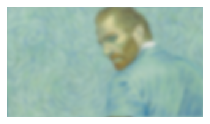

In [5]:
import numpy as np
from PIL import Image

img = np.array(Image.open('data/poster.jpg'), dtype=np.float32)
img_filtered = np.asarray(gaussian(img, 3))
show_image(img_filtered.astype(np.uint8))

### 2.1 双边滤波 (15分)

Image from Fast Bilateral Filtering for the Display of High-Dynamic-Range Images, Durand and Dorsey.
<img src="./data/bilateral_filtering.png"  style="width: 700px;display: inline-block;"/>

双边滤波在高斯滤波的基础上引入了一个和颜色强度相关的权重系数:

$$G(\mathbf p) = \frac{1}{w} \sum\limits_{q\in S} \mathcal{N}(|p-q|)\mathcal{N}(|I_p-I_q|)I_q$$
$$w = \sum\limits_{q\in S} \mathcal{N}(|p-q|)\mathcal{N}(|I_p-I_q|)$$

1. 编程实现 (10分)

In [6]:
def bilateral(im, sig_s, sig_c):
    ### sig_c is the variance of Color Gaussian
    ### sig_s is the variance of Spatial Gaussian
    height, width, _= im.shape
    img_filtered = np.zeros([height,width,3])
    ### YOUR CODE HERE
    gaussian = lambda d2, sigma: np.exp(-0.5 * d2 / sigma**2)
    win_size = int(np.floor(3 * sig_s))
    weight_sum = np.zeros_like(img_filtered)
    for sx in range(-win_size, win_size + 1):
        for sy in range(-win_size, win_size + 1):
            offset_img = np.roll(im, [sy, sx], axis=[0, 1])
            spatial = gaussian(sx**2 + sy**2, sig_s)
            color = gaussian((im - offset_img) ** 2, sig_c)
            weight = spatial * color
            img_filtered += offset_img * weight
            weight_sum += weight
    img_filtered /= weight_sum
    ### END YOUR CODE
    return img_filtered

2. 我们接下来用双边滤波对下面三个有噪声的图片进行降噪, 根据图像的特点（考虑颜色分布，语义内容，整体风格），选择合适的参数, 尽可能减小输出和ground truth)的L2误差(同时输出图片和误差值大小)，你的程序输入为一张图像，输出为L2误差以及降噪后的图片，将输出图片结果保存在`data/res`文件夹里(5分)

<img src="./data/noisy/sky.png"  style="height: 220px;display: inline-block;"/>
<img src="./data/noisy/noir.png"  style="height: 220px;display: inline-block;"/>
<img src="./data/noisy/fairy-meadows.png"  style="height: 220px;display: inline-block;"/>

<img src="./data/gt/sky.png"  style="height: 220px;display: inline-block;"/>
<img src="./data/gt/noir.png"  style="height: 220px;display: inline-block;"/>
<img src="./data/gt/fairy-meadows.png"  style="height: 220px;display: inline-block;"/>

> 

sky.png, per pixel/channel L2 error: (before)787.1074829101562, (after)50.296418992787046
noir.png, per pixel/channel L2 error: (before)474.9494934082031, (after)127.37217395392906
fairy-meadows.png, per pixel/channel L2 error: (before)843.323974609375, (after)289.213907264312


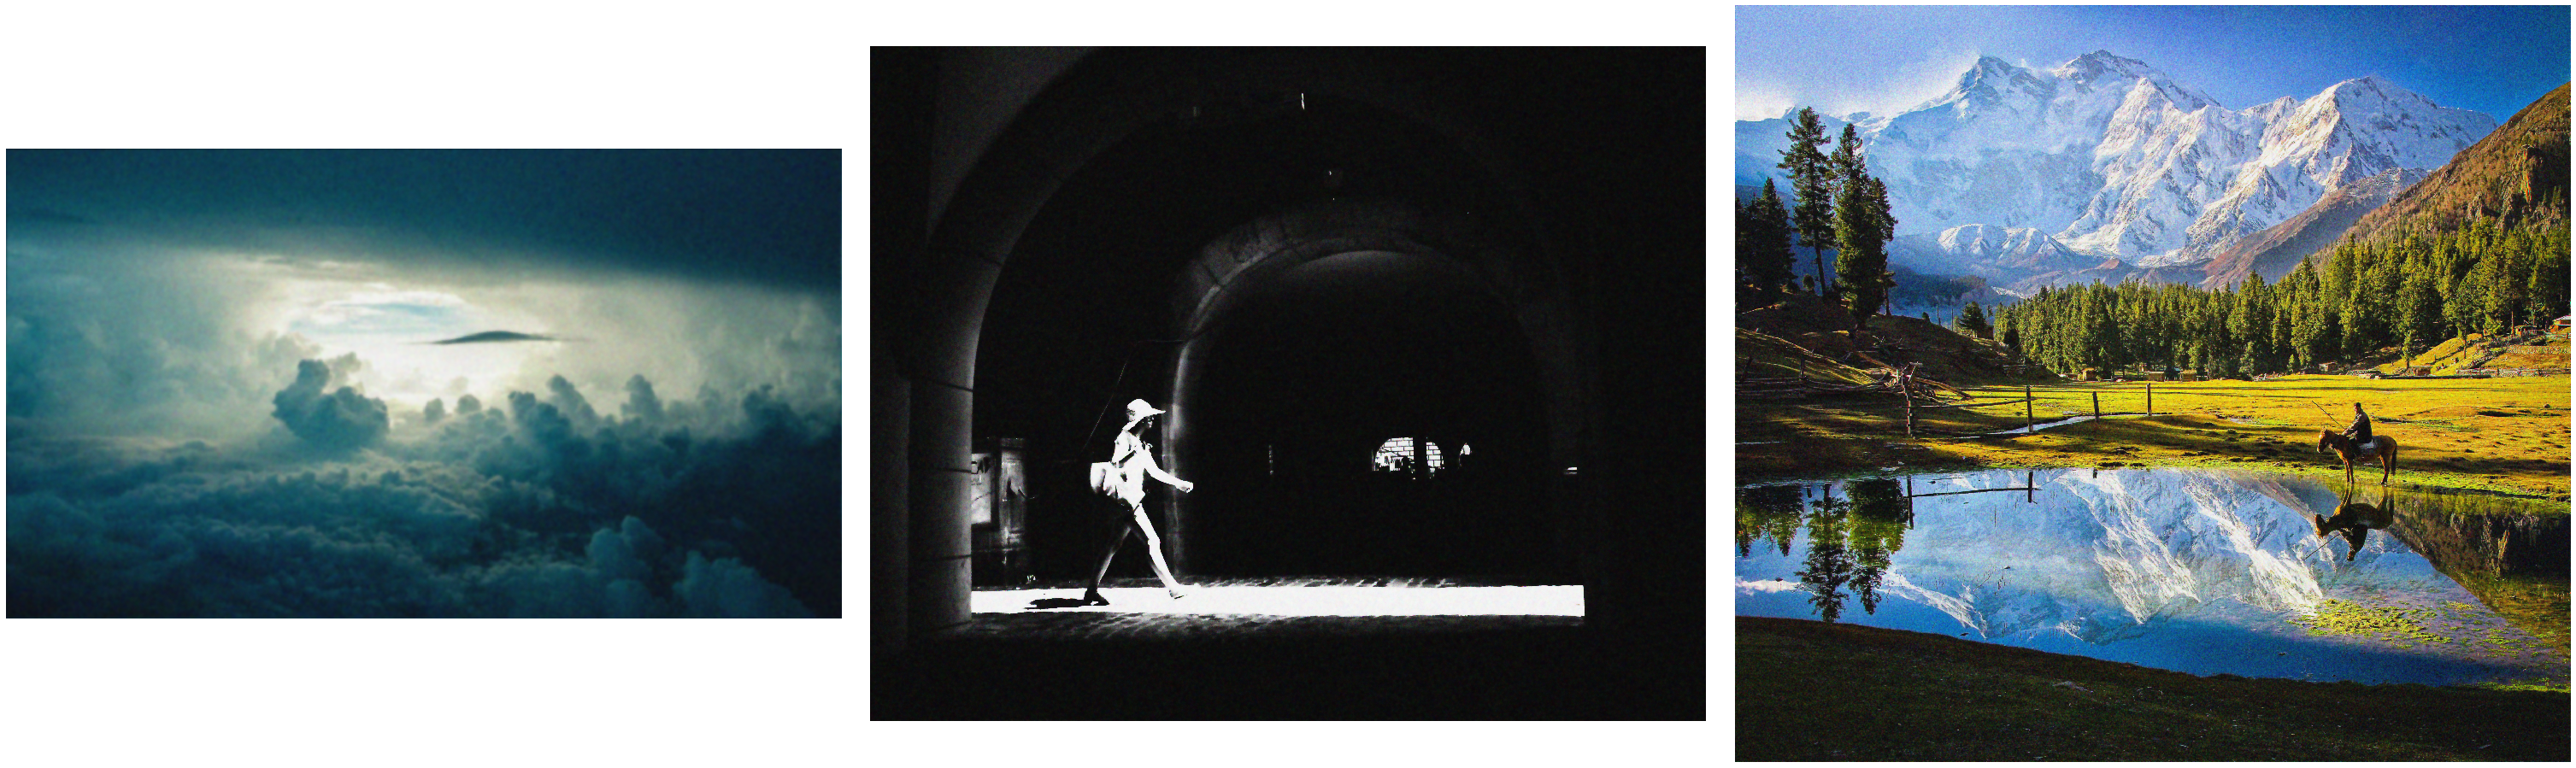

In [7]:
import numpy as np
from PIL import Image

names = ['sky.png', 'noir.png', 'fairy-meadows.png']

## for parameter tuning only
# def fastBilateral(img, sig_s, sig_c):
#     import cv2
#     ch = img.shape[2]
#     res = []
#     d = 2 * int(np.ceil(3 * sig_s)) + 1
#     for i in range(ch):
#         res.append(cv2.bilateralFilter(img[:, :, [i]], d, sig_c, sig_s))
#     return np.stack(res, axis=2)

### YOUR CODE HERE
params = [(3.3, 200), (2.34, 60), (1.11, 70)]
results = []

for name, (sig_s, sig_c) in zip(names, params):
    img = np.array(Image.open(f'./data/noisy/{name}'), dtype=np.float32)
    gt_img = np.array(Image.open(f'./data/gt/{name}'), dtype=np.float32)
    filtered_img = bilateral(img, sig_s, sig_c)
    # filtered_img = fastBilateral(img, sig_s, sig_c)
    # print(f"{np.mean(np.abs(filtered_img - filtered_gt))}")
    Image.fromarray(filtered_img.astype(np.uint8)).save(f'./data/res/{name}')
    print(f"{name}, per pixel/channel L2 error: (before){np.mean((img - gt_img)**2)}, (after){np.mean((filtered_img - gt_img)**2)}")
    results.append(filtered_img.astype(np.uint8))

show_images(results)
### END YOUR CODE

## 第三部分: 单应性 (10分) 

### 3.1 应用单应性矩阵进行图像warping (10分)

给定如下单应性矩阵参数
```python
H=[[  8.34566914e-01  -3.12962592e-02  -4.53681006e+02],
   [  1.29611862e-01   1.21225212e+00  -5.04967813e+02],
   [ -8.20263106e-04   1.45634346e-05   1.00000000e+00]]
```
请补充`applyHomography()`的代码,最后**可以将如图梵高的海报warp到公交车图像的海报位置上**

**要求实现最近邻插值(5分)与双线性差值(5分)**两种方式 (提示:`ndimage.map_coordinates`)

<img src="./data/bus.jpg"  style="width: 350px;display: inline-block;"/>
<img src="./data/poster.jpg"  style="width: 200px;display: inline-block;"/>
<img src="./data/bus_warp.png"  style="width: 350px;display: inline-block;"/>

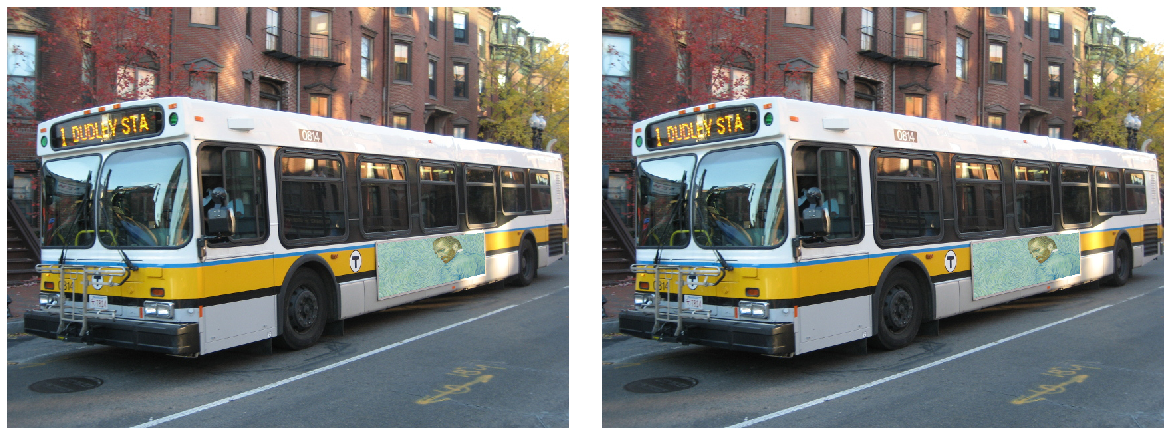

In [8]:
#homography matrix
H = np.array([[  8.34566914e-01 , -3.12962592e-02 , -4.53681006e+02],
              [  1.29611862e-01   ,1.21225212 , -5.04967813e+02],
              [ -8.20263106e-04  , 1.45634346e-05  , 1.]])

def applyHomography(H,im1,im2,option):
    #option = "nearest" or "bilinear"
    #warp image 2 to image 1
    im = im1 
    ### YOUR CODE HERE
    assert option in ['nearest', 'bilinear'], f'Unsupported interpolation method: {option}'
    order = 0
    if option == 'bilinear':
        order = 1
    h, w, ch = im1.shape
    ys, xs = np.mgrid[0:h, 0:w]
    coords = np.stack([ys, xs, np.ones_like(xs)], axis=2).reshape(-1, 3)
    # swap x,y for convenience
    H_proc = H.copy()
    H_proc[:, 0], H_proc[:, 1] = H[:, 1], H[:, 0]
    dst_coords = coords.dot(H_proc.T)
    dst_coords /= dst_coords[..., [2]]
    dst_coords = dst_coords[..., :2].reshape(-1, 2)
    res = []
    for ch in range(3):
        r = ndimage.map_coordinates(im2[..., ch], np.array([dst_coords[..., 1], dst_coords[..., 0]]), order=order)
        res.append(r)
    res = np.stack(res, axis=1).reshape(h, w, 3)
    im[res > 0] = 0
    im += res
    ### END YOUR CODE
    return im

img2=(io.imread("./data/poster.jpg"))
img1=(io.imread("./data/bus.jpg"))
show_images([applyHomography(H,img1,img2,"nearest"), applyHomography(H,img1,img2,"bilinear")])